# Developing a Model to Analyze Health Vials from Diablo 4 Screenshots

## Environment Setup

In [1]:
%%capture
%pip install torchvision matplotlib openpyxl Pillow scikit-learn

In [2]:
# Imports
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import torch
import torch.nn as nn

from openpyxl import Workbook, load_workbook
from openpyxl.drawing.image import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image as PILImage

## Common Utilities

This section includes utility functions that are common across various parts of the notebook, aimed at streamlining workflow and simplifying code reuse.

### Additional helper functions can be defined below as needed

In [3]:
# Utility function for displaying images with customized titles and axes
def display_image(image_path, fullness_value, barrier_present_value):
    """Display the image in the Jupyter output along with the threshold and barrier values."""
    img = mpimg.imread(image_path)  
    plt.imshow(img)
    plt.axis('off')  # Hide axes

    # Display threshold and barrier values below the image
    plt.title(f'Fullness: {fullness_value}, Barrier Present: {barrier_present_value}')
    plt.show()

## Training
Train a model to classify health vials and estimate their fill levels.  
<br>
### Semi-Supervised Learning
Use semi-supervised learning to create a sub-varient of the model to help with the labeleling process
<br>
#### Load labeled and unlabeled data

In [4]:
# Define the path for the datasets
base_path = os.path.expanduser('~/Desktop/health-vials/')
# Define the filename
filename = 'batch_annotations_full_size(labeled).json'

# Load labeled dataset
with open(os.path.join(base_path, filename), 'r') as f:
    labeled_data = json.load(f)

# Split the data into train, validation, and test sets
train_data, test_data = train_test_split(labeled_data, test_size=0.2, random_state=42)  # 80% Train, 20% Test
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)  # 10% Valid, 10% Test

In [5]:
# Create Custom Dataset
class VialDataset(Dataset):
    def __init__(self, data, is_labeled=True, transform=None):
        self.data = data
        self.is_labeled = is_labeled
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(base_path, item['image']) 
        image = PILImage.open(image_path).convert("RGB")

        try:
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error processing image: {image_path}, Error: {str(e)}")
            return None, None, None


        if self.is_labeled:
            # Return labeled data
            fullness = item['attributes']['fullness']
            barrier = item['attributes']['barrier']
            return image, torch.tensor([fullness], dtype=torch.float32), torch.tensor([int(barrier)], dtype=torch.float32)
        
        else:
            # Return only the image and empty tensors for unlabeled data
            return image, torch.zeros(1, dtype=torch.float32), torch.zeros(1, dtype=torch.float32)

In [6]:
# Define the model
class VialModel(nn.Module):
    def __init__(self):
        super(VialModel, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(16 * 118 * 118, 128),  # Adjust to match image size
            nn.ReLU()
        )
        self.fullness_head = nn.Linear(128, 1)  # Regression for fullness
        self.barrier_head = nn.Linear(128, 1)  # Classification for barrier

    def forward(self, x):
        x = self.backbone(x)
        fullness = self.fullness_head(x)
        barrier = torch.sigmoid(self.barrier_head(x))
        return fullness, barrier

In [7]:
# Create Custom Dataset for train, validation, and test
train_dataset = VialDataset(train_data, is_labeled=True, transform=transforms.ToTensor())
valid_dataset = VialDataset(valid_data, is_labeled=True, transform=transforms.ToTensor())
test_dataset = VialDataset(test_data, is_labeled=True, transform=transforms.ToTensor())

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the model
model = VialModel()

# Loss functions and optimizer
criterion_fullness = nn.MSELoss()  # Loss for regression
criterion_barrier = nn.BCELoss()  # Loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
model.train()
for epoch in range(20):  # Adjust epochs
    for images, fullness, barrier in train_loader:
        optimizer.zero_grad()
        pred_fullness, pred_barrier = model(images)
        loss_fullness = criterion_fullness(pred_fullness, fullness)
        loss_barrier = criterion_barrier(pred_barrier, barrier)
        loss = loss_fullness + loss_barrier
        loss.backward()
        optimizer.step()
    
    # Validation step
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for images, fullness, barrier in valid_loader:
            pred_fullness, pred_barrier = model(images)
            val_loss_fullness = criterion_fullness(pred_fullness, fullness)
            val_loss_barrier = criterion_barrier(pred_barrier, barrier)
            validation_loss += val_loss_fullness.item() + val_loss_barrier.item()

    print(f"Epoch {epoch+1}: Training Loss = {loss.item()}, Validation Loss = {validation_loss / len(valid_loader)}")

# Save the trained model
model_save_path = os.path.join(base_path, 'vial_model.pth')
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at: {model_save_path}')

Epoch 1: Training Loss = 4.079424858093262, Validation Loss = 2.1767295002937317
Epoch 2: Training Loss = 1.1793514490127563, Validation Loss = 1.164665937423706
Epoch 3: Training Loss = 0.7954403162002563, Validation Loss = 0.8112121671438217
Epoch 4: Training Loss = 0.5003991723060608, Validation Loss = 0.713524840772152
Epoch 5: Training Loss = 0.6212882995605469, Validation Loss = 0.717104010283947
Epoch 6: Training Loss = 0.5193569660186768, Validation Loss = 0.7238519322127104
Epoch 7: Training Loss = 0.4280242323875427, Validation Loss = 0.7330888956785202
Epoch 8: Training Loss = 0.25318488478660583, Validation Loss = 0.7011841349303722
Epoch 9: Training Loss = 0.4852161705493927, Validation Loss = 0.653079716488719
Epoch 10: Training Loss = 0.5459875464439392, Validation Loss = 0.564661399461329
Epoch 11: Training Loss = 0.3950231075286865, Validation Loss = 0.47724377689883113
Epoch 12: Training Loss = 0.3116234838962555, Validation Loss = 0.4157158141024411
Epoch 13: Trainin

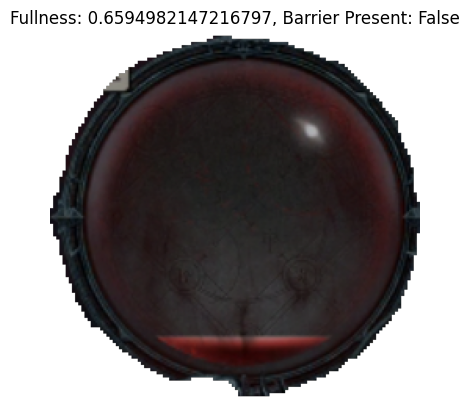

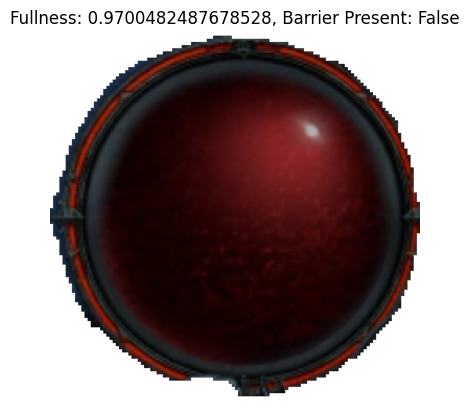

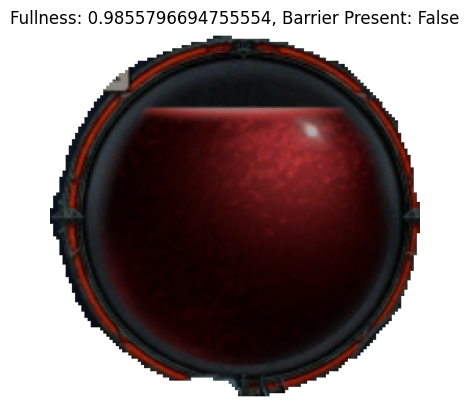

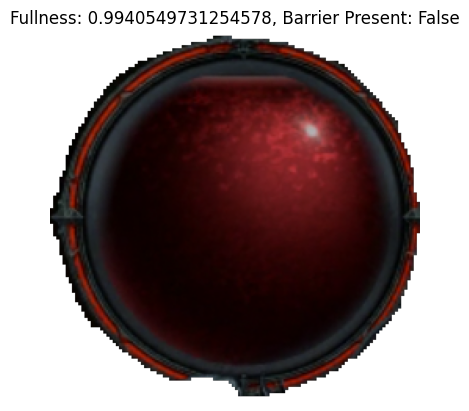

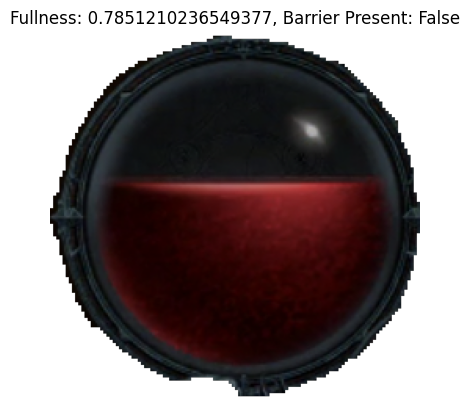

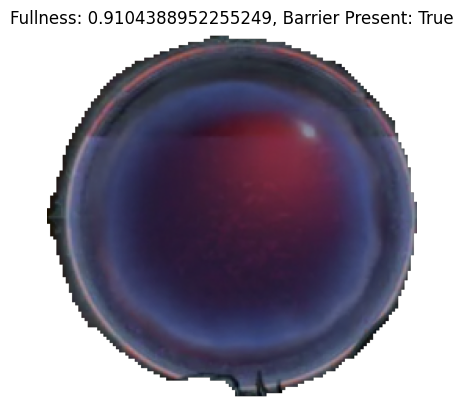

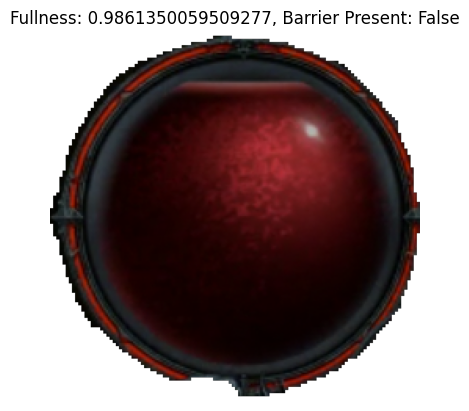

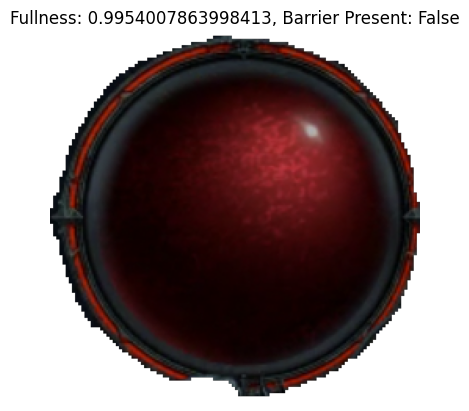

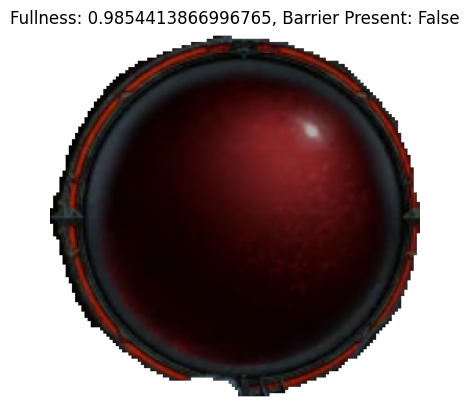

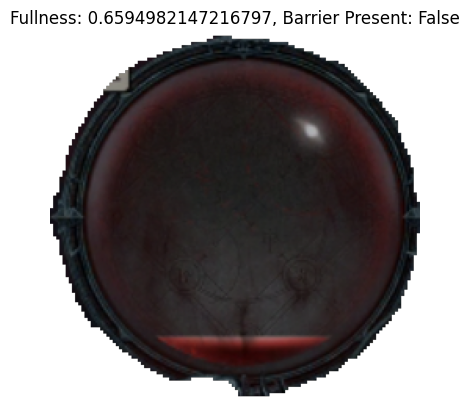

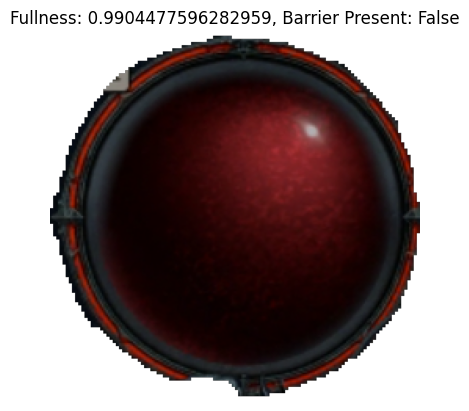

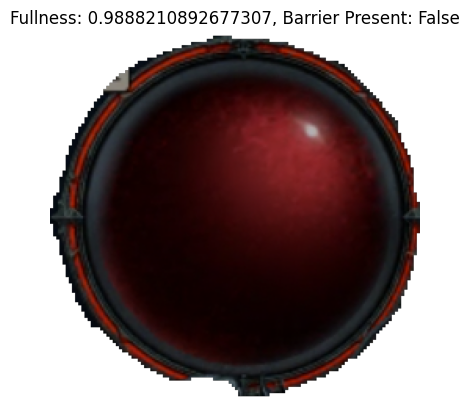

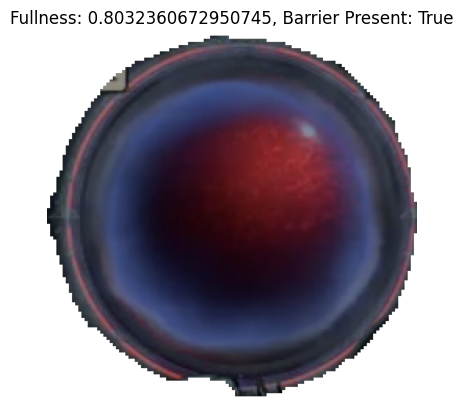

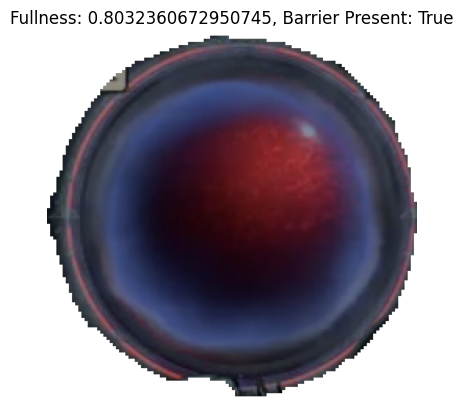

In [8]:
## Inference on test data
model.eval()
test_results = []
with torch.no_grad():
    for images, fullness, barrier in test_loader:
        pred_fullness, pred_barrier = model(images)
        for i in range(len(images)):
            test_results.append({
                "image": test_data[i]['image'],
                "bounding_box": test_data[i]['bounding_box'],
                "attributes": {
                    "fullness": float(pred_fullness[i].item()),
                    "barrier": bool(pred_barrier[i].item() > 0.5)
                }
            })

# Display test results with image previews
def display_test_results(test_results):
    """Display test results with image previews."""
    for result in test_results:
        # Extract the attributes and image path
        image_name = result['image']
        fullness = result['attributes']['fullness']
        barrier = result['attributes']['barrier']
        
        # Construct the image path
        image_path = os.path.join(base_path, image_name)

        # Display the image
        display_image(image_path, fullness, barrier)

# Call the function to display results
display_test_results(test_results)

# Save test results
with open('batch_annotations_test_results.json', 'w') as f:
    json.dump(test_results, f, indent=4)

## Inference

In this section, we will utilize the trained model to perform inference on health vial images extracted from screenshots. The goal is to predict two main attributes for each health vial:
- **Fullness**: A continuous value indicating how full the vial is (ranging from 0.0 to 1.0).
- **Barrier Presence**: A binary value indicating whether a barrier is present (True or False).

We will follow these steps:

1. **Load the Trained Model**: 
   - A pre-trained model will be loaded from a specified file path to make predictions on unseen images.

2. **Image Processing for Inference**: 
   - The function `process_images` is defined to process all images within a directory. For each image, the model will be queried to get the predictions for fullness and barrier presence.
   - It will also format the output by displaying each image alongside its respective predictions. 

3. **Display Predictions**: 
   - The `display_image` function is utilized to visually present each vial image together with formatted fullness and barrier information, making it easier to review the model’s output.

4. **Results Compilation**: 
   - An organized list of results is compiled, containing the image name, bounding box information (fixed values in this case), and predicted attributes (fullness and barrier presence).
  
5. **Exporting Results**: 
   - Finally, results from the inference phase are saved into an Excel file for human review. The results will include the images and attributes in an easy-to-read format.

This process will help in evaluating the model's performance and the accuracy of its predictions on the health vial images.

In [12]:
# Load the trained model for inference
def load_model(model_path):
    model = VialModel()  # Create a new instance of the model
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

def infer_health_vial(image_path, model):
    # Load and preprocess the image
    image = PILImage.open(image_path).convert("RGB")
    image = transforms.ToTensor()(image).unsqueeze(0)  # Add batch dimension
    
    with torch.no_grad():
        pred_fullness, pred_barrier = model(image)
        fullness = pred_fullness.item()
        barrier = bool(pred_barrier.item() > 0.5)  # Apply sigmoid and threshold
        return fullness, barrier

In [ ]:
def process_images(image_dir, model):
    """Process images for inference and apply filters based on thresholds."""
    # List all image files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # To hold results
    results = []
    
    # Define the bounding box (fixed coordinate values)
    bounding_box = {
        "x_min": 0,
        "y_min": 0,
        "x_max": 236,
        "y_max": 236
    }

    # Loop through each image file and perform inference
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)

        # Perform inference
        fullness, barrier = infer_health_vial(image_path, model)

        # Cleanup the fullness
        # 1. Round fullness to the nearest 0.05.
        # 2. Apply a ceiling to ensure the fullness does not exceed 1.0.
        fullness = round(min(fullness, 1.0) * 20) / 20 

        # Display the image
        display_image(image_path, fullness, barrier)

        # Construct result for current image
        result = {
            "image": image_file,
            "bounding_box": bounding_box,
            "attributes": {
                "fullness": fullness,
                "barrier": barrier
            }
        }
        
        # Append result to results list
        results.append(result)
    
    return results

In [ ]:
#base_path = os.path.join(os.getcwd(), '..') # one directory above the current working directory
base_path = os.path.expanduser('~/Desktop/health-vials')

# Load the trained model for inference
model_path = os.path.join(base_path, 'vial_model.pth')
model = load_model(model_path)

# Directory containing the images for inference
image_dir = os.path.expanduser('~/Desktop/health-vials-eval')

# Process images with specified filters
results = process_images(image_dir, model)

### Saving Inference Results for Human Review

In this section, we aim to compile the results from our inference process into a format that is easy for humans to review. The output will be structured in a way that displays relevant image attributes alongside the images themselves.

Key steps involved in this process include:

1. **Exporting Results to Excel**: 
   - The `export_results_excel_with_images` function creates a new Excel workbook and populates it with the inference results. Each entry includes the image, its name, the predicted fullness, and the barrier presence. This results in a spreadsheet that is user-friendly and enables easy sorting or filtering for manual review.

2. **Finalizing the Output**: 
   - Lastly, the Excel workbook is saved to a specified output path. This file serves as a detailed report for human reviewers, allowing for assessment of both the images and their predicted attributes.

By executing these steps, we ensure that the results from the model's predictions are easily accessible for validation, further analysis, and enhancement of the machine learning framework as needed.

In [ ]:
def export_results_excel_with_images(results, output_excel_path):
    """Export processed results to an Excel file with images."""
    # Create a new Excel workbook and a worksheet
    wb = Workbook()
    ws = wb.active
    ws.title = "Health Vials Results"

    # Write header
    ws.append(["Image", "Image Name", "Fullness", "Barrier"])

    # Loop through the results and add to Excel
    for result in results:
        # Add fullness and barrier values
        fullness = result['attributes']['fullness']
        barrier = result['attributes']['barrier']
        image_name = result['image']

        # Add the image
        image_path = os.path.join(image_dir, image_name)
        img = Image(image_path)  # Create an Image object
        img.width = 100  # Adjust the width (optional)
        img.height = 100  # Adjust the height (optional)
        
        # Append a new row in the sheet and insert image in the first column
        ws.append([None, image_name, fullness, barrier])  # Append empty cell for image
        ws.add_image(img, ws.cell(row=ws.max_row, column=1).coordinate) # Add image in the first column
        

    # Save the workbook
    wb.save(output_excel_path)

# Assuming 'results' is a list of dictionaries containing the needed information
output_path = os.path.expanduser("~/Desktop/health_vials_results.xlsx")
export_results_excel_with_images(results, output_path)

#### Import Back from Excel

In this section, we will read the inference results previously exported to an Excel file and reconstruct them for further use. 
- **Filtering Results**: Results are appended to a list only if the 'purge' status is `False`, ensuring that only valid entries are retained.
- **Constructing JSON Objects**: Each valid entry is transformed into a JSON object, with the image name, bounding box, and attributes (fullness and barrier) included.
- **Saving**: The json objects are saved to a file for further use in retraining the model.

In [ ]:
# Define the static bounding box
bounding_box = {
    "x_min": 0,
    "y_min": 0,
    "x_max": 236,
    "y_max": 236
}

def read_excel_and_construct_json(excel_path):
    # Load the workbook and the specific sheet
    workbook = load_workbook(excel_path)
    sheet = workbook.active

    results = []

    # Iterate through the rows of the sheet, starting from row 2 to skip the header
    for row in sheet.iter_rows(min_row=2, values_only=True):
        image, image_name, fullness, barrier, purge = row
        
        # Check if purge is FALSE
        if purge is False:
            result = {
                "image": image_name,
                "bounding_box": bounding_box,
                "attributes": {
                    "fullness": fullness,
                    "barrier": barrier,
                }
            }
            results.append(result)

    return results

# Specify the path to your Excel file
excel_path = os.path.expanduser("~/Desktop/health_vials_results.xlsx")
reconstructed_results = read_excel_and_construct_json(excel_path)

# Save results to a JSON file
output_json_path = os.path.expanduser("~/Desktop/health-vials/vial_inference_results.json")
with open(output_json_path, 'w') as json_file:
    json.dump(reconstructed_results, json_file, indent=4)

print(f"Results saved to {output_json_path}")

## Data Preparation Utilities

This section includes additional tools and functions designed to facilitate the preparation and processing of data required for training our health vial analysis model. These utilities streamline the workflow, ensuring that input images are correctly formatted and suitable for model training.

### Extract Health Vials from Screenshots

In this subsection, we will utilize a mask to automate the extraction of health vial images from high-resolution screenshots (1440p) of Diablo 4.

Key steps involved include:

1. **Applying the Mask**: 
   - The provided mask image (`../images/health-vial-mask.1440.png`) is used to identify and isolate health vials within the screenshots. This mask effectively filters the relevant portions of the images, ensuring that only the health vial contents are extracted for analysis.

2. **Image Resizing**: 
   - Once the health vial is extracted, the resulting image is resized slightly larger than the original dimensions, which helps maintain quality and clarity. A white background is used to ensure that the health vial images stand out, which is especially useful for subsequent training phases.

3. **Maintaining Consistency**:
   - The extraction process ensures that all health vials are represented with a uniform size and background. This consistency is crucial for training the model, as it allows the algorithm to focus on learning the features and patterns typical of health vials without variations due to size or background distractions.

By performing these operations, we enhance the overall quality and usability of the image data, thereby improving the robustness of the machine learning model during the training process.

In [ ]:
def extract_masked_content(input_image_path, output_image_path, mask_image_path='../images/health-vial-mask.1440.png'):
    # Open the input image
    img = Image.open(input_image_path).convert("RGBA")
    
    # Open the mask image and convert to greyscale
    mask = Image.open(mask_image_path).convert("L")  # Convert the mask to greyscale

    # Create a new image by applying the mask
    masked_data = []
    data = img.getdata()

    for index, item in enumerate(data):
        # Get mask pixel value (0: black, 255: white)
        mask_value = mask.getpixel((index % img.width, index // img.width))
        
        # If the mask pixel is white (255), keep the corresponding input image pixel
        if mask_value < 255:  # If not white, keep the pixel
            masked_data.append(item)  # Keep the original pixel
        else:
            masked_data.append((0, 0, 0, 0))  # Fully transparent pixel

    # Create a new image with the masked content
    masked_image = Image.new("RGBA", img.size)
    masked_image.putdata(masked_data)

    # Find the bounding box of the non-transparent pixels
    bbox = masked_image.getbbox()

    # Crop the image to the bounding box
    if bbox:
        cropped_image = masked_image.crop(bbox)

        # Create a new transparent image for resizing
        max_size = max(cropped_image.size)
        new_image = Image.new("RGBA", (max_size, max_size), (0, 0, 0, 0))  # Transparent background

        # Paste cropped image onto the center of the new transparent image
        new_image.paste(cropped_image, ((max_size - cropped_image.width) // 2, (max_size - cropped_image.height) // 2))

        # Save the result
        new_image.save(output_image_path, format="PNG")
    else:
        print("No visible content to extract.")

In [ ]:
# Define the base directories
input_base_dir = os.path.expanduser('~/Desktop/Diablo 4 Captures')
output_base_dir = os.path.expanduser('~/Desktop/health-vials-eval')

# Create the output directory if it doesn't exist
os.makedirs(output_base_dir, exist_ok=True)

# Get a list of all files in the input directory
all_files = os.listdir(input_base_dir)

# Filter to get only PNG files
png_image_paths = [os.path.join(input_base_dir, f) for f in all_files if f.endswith('.png')]

# Process each PNG image
for input_image_path in png_image_paths:
    # Construct the output image path
    output_image_path = os.path.join(output_base_dir, f'extracted_{os.path.basename(input_image_path)}')
    
    extract_masked_content(input_image_path, output_image_path)
    print(f'Processing {input_image_path} => {output_image_path}')

### Crop and Resize Screenshots

In this subsection, we will preprocess screenshots captured at a resolution of 3360x2100, which include 105 pixels of letterboxing at the top and bottom margins. Please note that this process can be slow, especially when handling large numbers of images.

1. **Crop the Images**: 
   - We will remove 105 pixels from both the top and bottom of each screenshot to eliminate unwanted interface elements. This step ensures that the analysis focuses solely on the relevant content of the images.

2. **Resize the Images**: 
   - After cropping, the images will be resized to a standardized resolution of 2560x1440 pixels. This consistency is vital for the model’s training, as it requires uniform input sizes across all images.

These preprocessing steps enhance the quality of the input images from this specific setup, leading to more efficient and effective model training and inference, albeit potentially at the cost of processing time.

In [ ]:
# Define the path to your desktop
images_path = os.path.expanduser("~/Desktop")

# Loop through all files in the directory
for file_name in os.listdir(images_path):
    if file_name.endswith(".png"):  # Process only PNG files
        file_path = os.path.join(images_path, file_name)
        
        # Open the image
        with PILImage.open(file_path) as img:
            width, height = img.size
            
            # Check if the image dimensions are 3360 x 2100
            if (width, height) == (3360, 2100):
                
                # Crop the image to remove 105px from top and bottom
                cropped_img = img.crop((0, 105, width, height - 105))

                # Resize the cropped image to 2560x1440 if it isn't already
                resized_img = cropped_img.resize((2560, 1440), PILImage.LANCZOS)
                
                # Save the resized image (overwrite the original file)
                cropped_img.save(file_path)